=== Monte Carlo settings ===
num_draws = 1000, seed = 12345
sigma_e0 = 0.15, sigma_a = 0.35
subsidy_effect = 0.6, subsidy_cost_weight = 0.05
CI method = empirical percentile (2.5%,97.5%)
Python 3.11.13, numpy 2.0.2



MC draws: 100%|██████████| 1000/1000 [03:00<00:00,  5.53it/s]


Saved mc_results_snapshot.npz


Scenario BAU:
 BR mean=139.208, std=10.035, 2.5%=121.648, 97.5%=159.898
 Coop mean=81.239, std=8.116, 2.5%=67.023, 97.5%=97.763

Scenario CarbonTax_10:
 BR mean=117.820, std=9.590, 2.5%=101.033, 97.5%=137.389
 Coop mean=77.832, std=8.065, 2.5%=63.760, 97.5%=94.524

Scenario Domestic_Subsidy:
 BR mean=134.052, std=9.901, 2.5%=116.636, 97.5%=154.120
 Coop mean=72.864, std=7.707, 2.5%=59.459, 97.5%=88.668
Saved br_vs_coop_distribution.png


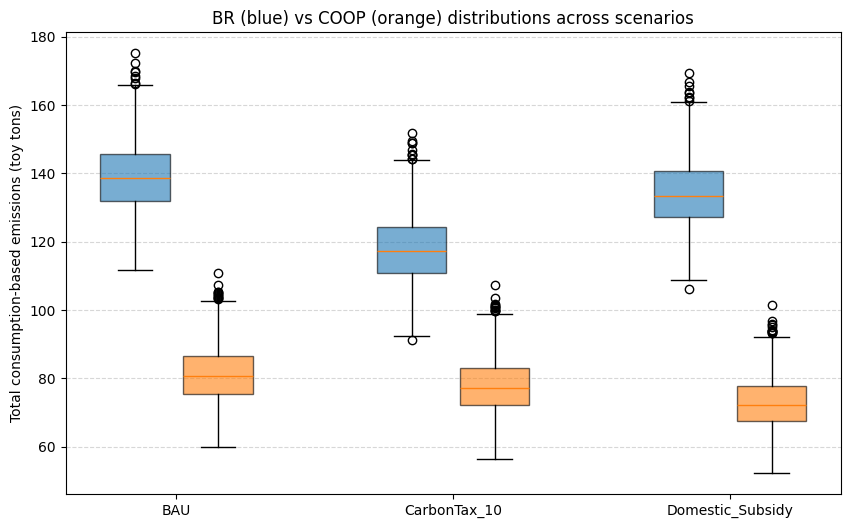

Saved total_consumption_emission_histogram.png


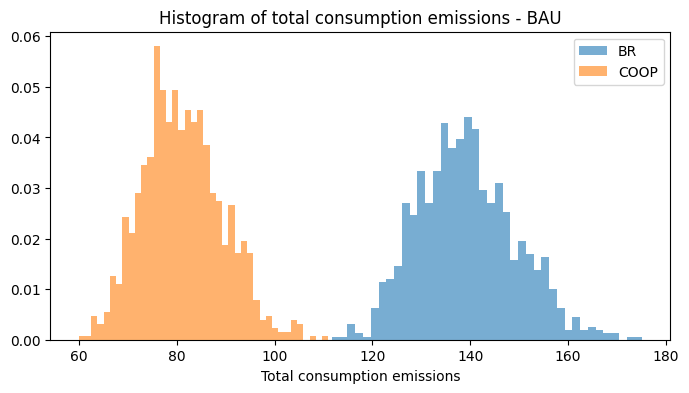

In [ ]:


import numpy as np
from scipy.optimize import minimize_scalar, minimize
import matplotlib.pyplot as plt
from tqdm import trange
import platform

# ---------------------------
# Synthetic base data
# ---------------------------
def make_synthetic_data(kappa=0.05, eta=1.6):
    J_dom = 4
    K_foreign = 3
    n_players = J_dom + K_foreign

    e0_dom = np.array([10.0,  6.0,  8.0,  4.0])
    e0_foreign = np.array([30.0, 50.0, 40.0])
    e0 = np.concatenate([e0_dom, e0_foreign])

    # square (n x n) MRIO: rows = consumers, cols = producers
    A_base = np.zeros((n_players, n_players))
    dom_share = 0.6
    for j in range(J_dom):
        A_base[j, :J_dom] = dom_share / J_dom
        A_base[j, J_dom:] = (1 - dom_share) / K_foreign
    # copy the same pattern to foreign consumer rows (toy)
    for j in range(J_dom, n_players):
        A_base[j, :] = A_base[j % J_dom, :]

    c_dom = np.array([100.0, 80.0, 120.0, 60.0])  # not directly used in this toy

    a = np.concatenate([np.array([1.0, 1.2, 0.9, 1.5]),
                        np.array([0.8, 1.1, 1.3])])
    s = np.zeros(n_players)
    r0 = np.zeros(n_players)

    # damage internalization shares (who feels global damage fraction)
    gamma = np.ones(n_players) / n_players  # uniform by default

    # params for new pieces
    beta = 0.6   # strength of green preference in trade matrix A(r)
    eps = 1e-6   # numerical guard for cost near r=1

    return {
        "J_dom": J_dom, "K_foreign": K_foreign, "n": n_players,
        "e0": e0, "A_base": A_base, "c_dom": c_dom, "a": a, "s": s, "r0": r0,
        "gamma": gamma, "kappa": kappa, "eta": eta, "beta": beta, "eps": eps
    }

# ---------------------------
# Endogenous A(r) + accounting
# ---------------------------
def A_endogenous(A_base, r, beta):
    """
    Column-scale A_base by (1 + beta * r_i) and renormalize each row to sum to 1.
    """
    scale = (1.0 + beta * r)  # shape (n,)
    A_scaled = A_base * scale[np.newaxis, :]  # column-wise scaling via broadcast
    row_sums = A_scaled.sum(axis=1, keepdims=True)
    # guard against zero rows
    row_sums[row_sums == 0] = 1.0
    return A_scaled / row_sums

def consumption_based_emissions(e0, r, A_base, beta, c_dom=None):
    """
    Uses endogenous A(r). Returns (cons_by_consumer, total_cons_em, e_prod, A_r)
    """
    A_r = A_endogenous(A_base, r, beta)
    e_prod = e0 * (1 - r)
    cons_by_consumer = A_r.dot(e_prod)
    total_cons_em = cons_by_consumer.sum()
    return cons_by_consumer, total_cons_em, e_prod, A_r

# ---------------------------
# Payoffs including nonlinear cost & damage with A(r)
# ---------------------------
def player_payoffs(e0, r, A_base, a, s, gamma, kappa, eta, beta,
                   carbon_tax=0.0, import_tariff=None, eps=1e-6):
    n = len(e0)
    cons_by_consumer, total_cons_em, e_prod, A_r = consumption_based_emissions(e0, r, A_base, beta)
    # emissions assigned to each producer = e_prod * column_sums(A_r)
    col_sums = A_r.sum(axis=0)
    assigned = e_prod * col_sums

    # Nonlinear abatement cost (blows up near r->1)
    C = a * (e0 * r)**2 / (1.0 - r + eps)

    # Subsidy paid per unit abatement output (kept linear in r for clarity)
    P = s * (e0 * r)

    # Carbon tax on assigned production emissions
    T = np.zeros(n)
    if carbon_tax and carbon_tax != 0.0:
        T += carbon_tax * assigned
    if import_tariff is not None:
        T += import_tariff * assigned

    # Nonlinear global damage, each player internalizes gamma_i share
    damage = kappa * (total_cons_em ** eta)   # scalar
    D_vec = gamma * damage

    U = -C + P - T - D_vec
    return U, assigned, total_cons_em, C.sum(), P.sum(), T.sum(), D_vec.sum(), A_r

def carbon_tax_term(e0, r, A_base, beta, carbon_tax=0.0):
    if carbon_tax == 0.0:
        return 0.0
    _, _, e_prod, A_r = consumption_based_emissions(e0, r, A_base, beta)
    assigned = e_prod * A_r.sum(axis=0)
    return carbon_tax * assigned.sum()

# ---------------------------
# Best-response solver (iterated BR)
# ---------------------------
def best_response_nash(e0, A_base, a, s, gamma, kappa, eta, beta,
                       r0=None, carbon_tax=0.0, import_tariff=None,
                       max_iters=600, tol=1e-6, verbose=False, eps=1e-6):
    n = len(e0)
    r = np.zeros(n) if r0 is None else r0.copy()
    history = [r.copy()]
    upper = 1.0 - 1e-6  # avoid singular cost at 1

    for it in range(max_iters):
        r_old = r.copy()
        for i in range(n):
            def neg_util_single(ri):
                r_temp = r.copy()
                r_temp[i] = ri
                U, *_ = player_payoffs(
                    e0, r_temp, A_base, a, s, gamma, kappa, eta, beta,
                    carbon_tax, import_tariff, eps=eps
                )
                return -float(U[i])
            res = minimize_scalar(neg_util_single, bounds=(0.0, upper),
                                  method='bounded', options={'xatol':1e-6})
            r[i] = float(res.x)
        history.append(r.copy())
        if np.linalg.norm(r - r_old) < tol:
            break

    U, assigned, total_cons_em, Csum, Psum, Tsum, Dsum, A_r = player_payoffs(
        e0, r, A_base, a, s, gamma, kappa, eta, beta, carbon_tax, import_tariff, eps=eps
    )
    return r, U, assigned, total_cons_em, Csum, Psum, Tsum, Dsum, np.array(history), A_r

# ---------------------------
# Cooperative solver (social planner)
# ---------------------------
def cooperative_solution(e0, A_base, a, s, gamma, kappa, eta, beta,
                         carbon_tax=0.0, weight_cost=1.0, SCC=50.0,
                         subsidy_effect=0.0, subsidy_cost_weight=1.0,
                         eps=1e-6):
    """
    - a_eff = a * (1 - subsidy_effect * s) (optional)
    - Planner objective:  SCC*E_total + weight_cost*Cost + subsidy_cost_weight*Subsidy + carbon_tax_term + Damage(E)
    """
    n = len(e0)
    a_eff = a * (1 - subsidy_effect * s)
    upper = 1.0 - 1e-6

    def obj(r_vec):
        r_vec = np.clip(r_vec, 0.0, upper)
        _, total_cons_em, _, _ = consumption_based_emissions(e0, r_vec, A_base, beta)
        cost = np.sum(a_eff * (e0 * r_vec)**2 / (1.0 - r_vec + eps))
        subsidy_cost = np.sum(s * (e0 * r_vec))
        tax_term = carbon_tax_term(e0, r_vec, A_base, beta, carbon_tax=carbon_tax)
        damage = kappa * (total_cons_em ** eta)
        return (SCC * total_cons_em
                + weight_cost * cost
                + subsidy_cost_weight * subsidy_cost
                + tax_term
                + damage)

    bounds = [(0.0, upper)] * n
    res = minimize(obj, np.zeros(n), bounds=bounds, method='SLSQP',
                   options={'ftol':1e-7, 'maxiter':1200})
    r_opt = np.clip(res.x, 0.0, upper)

    # report components at optimum (use a_eff for cost in reporting consistency)
    U, assigned, total_cons_em, _, Psum, Tsum, Dsum, A_r = player_payoffs(
        e0, r_opt, A_base, a_eff, s, gamma, kappa, eta, beta, carbon_tax, eps=eps
    )
    # recompute cost with a_eff to return an aggregate cost number
    Csum = np.sum(a_eff * (e0 * r_opt)**2 / (1.0 - r_opt + eps))
    return r_opt, assigned, total_cons_em, Csum, Psum, Tsum, Dsum, res, A_r

# ---------------------------
# Sampling helpers (lognormal)
# ---------------------------
def lognormal_params_from_mean_std(mean, rel_std):
    sigma_rel = max(1e-12, rel_std)
    sigma_log = np.sqrt(np.log(1 + sigma_rel**2))
    mu_log = np.log(mean) - 0.5 * sigma_log**2
    return mu_log, sigma_log

def sample_parameters(base_e0, base_a, sigma_e0=0.15, sigma_a=0.35, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    mu_e, s_e = lognormal_params_from_mean_std(base_e0, sigma_e0)
    e0_sample = rng.lognormal(mean=mu_e, sigma=s_e, size=base_e0.shape)
    mu_a, s_a = lognormal_params_from_mean_std(base_a, sigma_a)
    a_sample = rng.lognormal(mean=mu_a, sigma=s_a, size=base_a.shape)
    return e0_sample, a_sample

# ---------------------------
# Monte Carlo runner (default M=1000)
# ---------------------------
def monte_carlo_uncertainty(num_draws=1000, sigma_e0=0.15, sigma_a=0.35, scenarios=None,
                            verbose=True, seed=12345, subsidy_effect=0.6, subsidy_cost_weight=0.05,
                            kappa_override=None, eta_override=None, beta_override=None):
    print("=== Monte Carlo settings ===")
    print(f"num_draws = {num_draws}, seed = {seed}")
    print(f"sigma_e0 = {sigma_e0}, sigma_a = {sigma_a}")
    print(f"subsidy_effect = {subsidy_effect}, subsidy_cost_weight = {subsidy_cost_weight}")
    print(f"CI method = empirical percentile (2.5%,97.5%)")
    print(f"Python {platform.python_version()}, numpy {np.__version__}")
    print("============================\n")

    data = make_synthetic_data()
    base_e0 = data["e0"]; base_a = data["a"]
    A_base = data["A_base"]; s_base = data["s"]; r0 = data["r0"]
    gamma = data["gamma"]; kappa = data["kappa"]; eta = data["eta"]
    beta = data["beta"]; eps = data["eps"]
    n = data["n"]

    if kappa_override is not None: kappa = kappa_override
    if eta_override is not None:   eta = eta_override
    if beta_override is not None:  beta = beta_override

    rng = np.random.default_rng(seed)

    if scenarios is None:
        scenarios = {
            "BAU": {"carbon_tax": 0.0, "s": np.zeros(n), "SCC": 50.0},
            "CarbonTax_10": {"carbon_tax": 10.0, "s": np.zeros(n), "SCC": 50.0},
            "Domestic_Subsidy": {
                "carbon_tax": 0.0,
                "s": np.concatenate([np.ones(data["J_dom"])*1.5, np.zeros(n-data["J_dom"])]),
                "SCC": 50.0
            },
        }

    results = {name: {"BR_total": [], "COOP_total": [], "BR_r": [], "COOP_r": []}
               for name in scenarios.keys()}

    iters = trange(num_draws, desc="MC draws") if verbose else range(num_draws)
    for _ in iters:
        e0_samp, a_samp = sample_parameters(base_e0, base_a, sigma_e0=sigma_e0, sigma_a=sigma_a, rng=rng)
        for name, params in scenarios.items():
            s_local   = params.get("s", np.zeros(n))
            carbon_tx = params.get("carbon_tax", 0.0)
            SCC       = params.get("SCC", 50.0)

            # Best-response (strategic because of A(r) and D(E))
            r_br, U_br, assigned_br, total_br, Cbr, Pbr, Tbr, Dbr, hist, A_r_br = best_response_nash(
                e0_samp, A_base, a_samp, s_local, gamma, kappa, eta, beta,
                r0=None, carbon_tax=carbon_tx, import_tariff=None,
                max_iters=600, tol=1e-6, verbose=False
            )

            # Cooperative planner
            r_coop, assigned_coop, total_coop, Ccoop, Pcoop, Tcoop, Dcoop, res, A_r_coop = cooperative_solution(
                e0_samp, A_base, a_samp, s_local, gamma, kappa, eta, beta,
                carbon_tax=carbon_tx, weight_cost=1.0, SCC=SCC,
                subsidy_effect=subsidy_effect, subsidy_cost_weight=subsidy_cost_weight
            )

            results[name]["BR_total"].append(total_br)
            results[name]["COOP_total"].append(total_coop)
            results[name]["BR_r"].append(r_br)
            results[name]["COOP_r"].append(r_coop)

    # to arrays
    for name in results:
        results[name]["BR_total"]  = np.array(results[name]["BR_total"])
        results[name]["COOP_total"] = np.array(results[name]["COOP_total"])
        results[name]["BR_r"]      = np.stack(results[name]["BR_r"], axis=0)
        results[name]["COOP_r"]    = np.stack(results[name]["COOP_r"], axis=0)

    np.savez("mc_results_snapshot.npz", results=results, seed=seed, num_draws=num_draws,
             sigma_e0=sigma_e0, sigma_a=sigma_a, subsidy_effect=subsidy_effect,
             subsidy_cost_weight=subsidy_cost_weight, kappa=kappa, eta=eta, beta=beta)
    print("Saved mc_results_snapshot.npz\n")
    return results

# ---------------------------
# Plot & summarize
# ---------------------------
def summarize_and_plot_mc(results, save_figs=True, ci_method="percentile"):
    scenario_names = list(results.keys())

    # Summary + CI
    for name in scenario_names:
        br = results[name]["BR_total"]
        coop = results[name]["COOP_total"]
        M = br.size
        if ci_method == "percentile":
            br_ci = np.percentile(br, [2.5, 97.5])
            coop_ci = np.percentile(coop, [2.5, 97.5])
        else:
            br_se = br.std(ddof=1)/np.sqrt(M)
            coop_se = coop.std(ddof=1)/np.sqrt(M)
            br_ci = (br.mean() - 1.96*br_se, br.mean() + 1.96*br_se)
            coop_ci = (coop.mean() - 1.96*coop_se, coop.mean() + 1.96*coop_se)

        print(f"\nScenario {name}:")
        print(f" BR mean={br.mean():.3f}, std={br.std():.3f}, 2.5%={br_ci[0]:.3f}, 97.5%={br_ci[1]:.3f}")
        print(f" Coop mean={coop.mean():.3f}, std={coop.std():.3f}, 2.5%={coop_ci[0]:.3f}, 97.5%={coop_ci[1]:.3f}")

    # Boxplot: BR vs COOP
    fig, ax = plt.subplots(figsize=(10,6))
    br_data = [results[n]["BR_total"] for n in scenario_names]
    coop_data = [results[n]["COOP_total"] for n in scenario_names]
    positions_br = np.arange(len(scenario_names))*2.0 - 0.3
    positions_coop = np.arange(len(scenario_names))*2.0 + 0.3
    ax.boxplot(br_data, positions=positions_br, widths=0.5, patch_artist=True,
               boxprops=dict(facecolor='C0', alpha=0.6))
    ax.boxplot(coop_data, positions=positions_coop, widths=0.5, patch_artist=True,
               boxprops=dict(facecolor='C1', alpha=0.6))
    ax.set_xticks(np.arange(len(scenario_names))*2.0)
    ax.set_xticklabels(scenario_names)
    ax.set_ylabel("Total consumption-based emissions (toy tons)")
    ax.set_title("BR (blue) vs COOP (orange) distributions across scenarios")
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    if save_figs:
        fig.savefig("br_vs_coop_distribution.png", dpi=300, bbox_inches='tight')
        print("Saved br_vs_coop_distribution.png")
    plt.show()

    # Histograms for first scenario
    first = scenario_names[0]
    plt.figure(figsize=(8,4))
    plt.hist(results[first]["BR_total"], bins=40, alpha=0.6, label='BR', density=True)
    plt.hist(results[first]["COOP_total"], bins=40, alpha=0.6, label='COOP', density=True)
    plt.legend()
    plt.title(f"Histogram of total consumption emissions - {first}")
    plt.xlabel("Total consumption emissions")
    if save_figs:
        plt.savefig("total_consumption_emission_histogram.png", dpi=300, bbox_inches='tight')
        print("Saved total_consumption_emission_histogram.png")
    plt.show()

# ---------------------------
# Convergence diagnostic helper
# ---------------------------
def convergence_diagnostic(M_list=[200,500,1000,2000], sigma_e0=0.15, sigma_a=0.35, seed=12345):
    print("Running convergence diagnostic for different M values:")
    for M in M_list:
        results = monte_carlo_uncertainty(num_draws=M, sigma_e0=sigma_e0, sigma_a=sigma_a,
                                          verbose=False, seed=seed)
        br_mean = results["BAU"]["BR_total"].mean()
        br_ci = np.percentile(results["BAU"]["BR_total"], [2.5,97.5])
        print(f" M={M:5d} | BAU BR mean={br_mean:.3f} | CI=[{br_ci[0]:.3f},{br_ci[1]:.3f}]")

# ---------------------------
# If run as script
# ---------------------------
if __name__ == "__main__":
    # Example run: M=1000
    M = 1000
    seed = 12345
    sigma_e0 = 0.15
    sigma_a = 0.35
    subsidy_effect = 0.6
    subsidy_cost_weight = 0.05

    # nonlinear damage & endogenous A intensity (tweak if needed)
    kappa_override = 0.05
    eta_override   = 1.6
    beta_override  = 0.6

    results = monte_carlo_uncertainty(
        num_draws=M, sigma_e0=sigma_e0, sigma_a=sigma_a,
        verbose=True, seed=seed, subsidy_effect=subsidy_effect,
        subsidy_cost_weight=subsidy_cost_weight,
        kappa_override=kappa_override, eta_override=eta_override,
        beta_override=beta_override
    )
    summarize_and_plot_mc(results, save_figs=True, ci_method="percentile")

    # optional: convergence_diagnostic([200,500,1000], sigma_e0=sigma_e0, sigma_a=sigma_a, seed=seed)
